In [1]:
import cv2
import qrcode
import numpy as np
import matplotlib.pyplot as plt

import config
from utils import *

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

In [3]:
def generate_qr_code(student_name, debug=False):
    qr = qrcode.QRCode(
        version=10,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=2,
        border=4,
    )
    qr.add_data(student_name)
    qr.make(fit=True)
    QRcode = qr.make_image(fill_color="black", back_color="white")
    rgb_QRcode = QRcode.convert('RGB')
    if debug:
        display(rgb_QRcode)
    bgr_QRcode = np.array(rgb_QRcode)[:, :, ::-1].copy()
    return bgr_QRcode

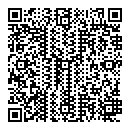

In [4]:
qr = generate_qr_code('Althayr Santos de Nazaret', True);

In [5]:
qr.shape

(130, 130, 3)

## Generating the options to choose image

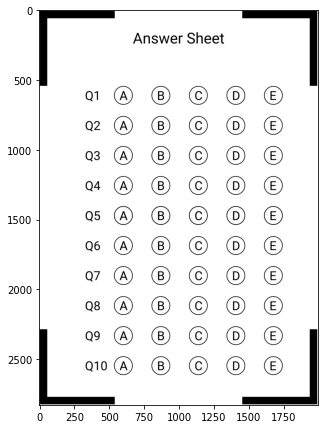

In [6]:
source_template = cv2.imread("./images/grade_form.png")
plt.imshow(to_rgb(source_template));

In [7]:
source_template.shape

(2828, 2000, 3)

In [8]:
source_template[530:680, 520:1750,:].shape

(150, 1230, 3)

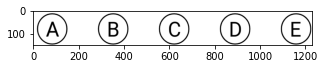

In [9]:
img_mark_options = source_template[530:680, 520:1750,:]
cv2.imwrite('mark_options.jpg', img_mark_options)
plt.imshow(img_mark_options);

(50, 50, 3)


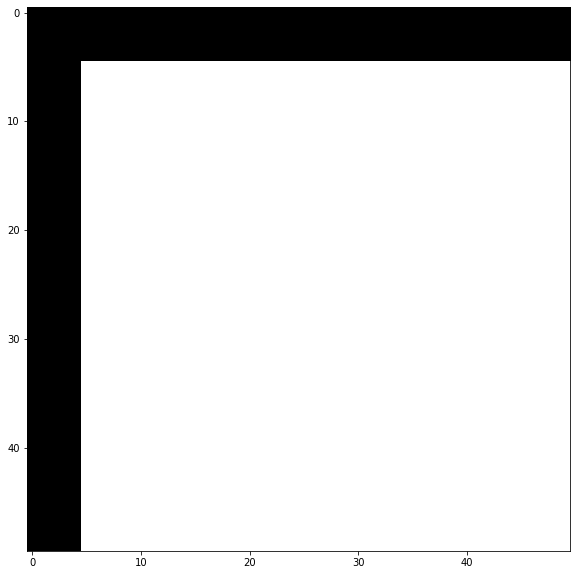

In [13]:
corner = cv2.imread("./images/corner.png")
corner = cv2.resize(corner, (50, 50))
print(corner.shape)
plot_bgr(corner);

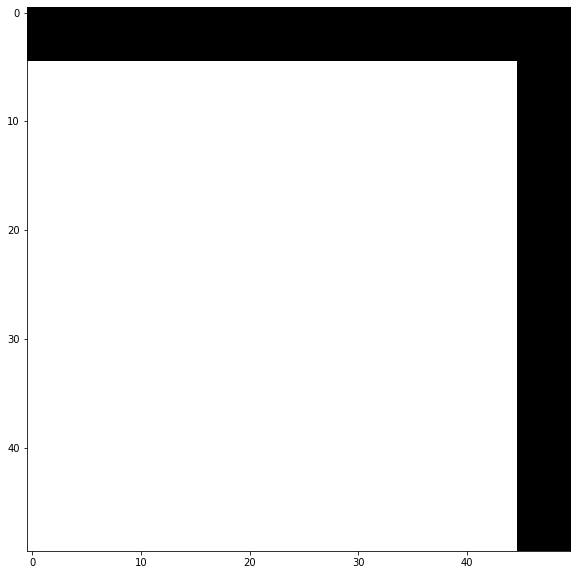

In [57]:
plot_bgr(cv2.rotate(corner, 0));

In [88]:
def insert_corners(img):
    corner = cv2.imread("./images/corner.png")
    corner = cv2.resize(corner, (100, 100))
    
    # tl, tr, br, bl
    corners = [
        corner,
        cv2.rotate(corner, 0),
        cv2.rotate(corner, 1),
        cv2.rotate(corner, 2)
    ]
    coords = [
        [0, 100, 0, 100], 
        [config.TEMPLATE_DIMS[1] - 100, config.TEMPLATE_DIMS[1], 0, 100],
        [config.TEMPLATE_DIMS[1] - 100, config.TEMPLATE_DIMS[1], config.TEMPLATE_DIMS[0] - 100, config.TEMPLATE_DIMS[0]],
        [0, 100, config.TEMPLATE_DIMS[0] - 100, config.TEMPLATE_DIMS[0]]
    ]
    img = img.copy()
    for corner, coord in zip(corners, coords):
        img = insert_image(img, corner, *coord)
    return img

## Generating the complete student sheet

In [90]:
def generate_blank_slate(w, h):
    return 255*np.ones(shape=(w, h, 3),dtype=np.int16)

def insert_qrcode(text, img, y_range, x_range):
    img = img.copy()
    qr = generate_qr_code(text)
    img[x_range[0]:x_range[1], y_range[0]:y_range[1], :] = qr
    return img

def insert_text(student_sheet, title):
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(student_sheet,
                title,
                org=(config.QRCODE_BORDER_SIZE,100),
                fontFace=font,
                fontScale=0.8,
                color=(0,0,0),
                thickness=2,
                lineType=cv2.LINE_AA)
    return student_sheet

def produce_mark_sheet(student_name, title='Answer Sheet'):
    mark_sheet = generate_blank_slate(config.TEMPLATE_DIMS[0], config.TEMPLATE_DIMS[1])
    mark_sheet = insert_corners(mark_sheet)
    mark_sheet = insert_qrcode(student_name, mark_sheet, config.QRCODE_W_RANGE, config.QRCODE_H_RANGE)
    mark_sheet = insert_all_mark_options(mark_sheet)
    mark_sheet = insert_text(mark_sheet, title=title)
    return mark_sheet

def insert_image(base_img, other_img, lower_x, upper_x, lower_y, upper_y):
    base_img = base_img.copy()
    other_img = other_img.copy()
    base_img[lower_y:upper_y, lower_x:upper_x, :] = other_img
    return base_img


def get_template_mark_options():
    mark_options = cv2.imread("./images/mark_options.jpg")
    mark_options = cv2.resize(mark_options,
                              config.MARKS_DIMS[::-1],
                              interpolation=cv2.INTER_AREA)
    # Adding vertical spacing between images
    shape = (config.MARKS_VERTICAL_SPACING_SIZE+config.MARKS_DIMS[0], config.MARKS_DIMS[1], 3)
    canvas = 255*np.ones(shape=shape,dtype=np.int16)
    
    mark_options = insert_image(canvas,
                                mark_options,
                                0,
                                config.MARKS_DIMS[1],
                                0,
                                config.MARKS_DIMS[0])  
    return mark_options

def insert_all_mark_options(mark_sheet):

    mark_options = get_template_mark_options()
    
    # Inserting answers for column 1
    answers_block_size = config.MARKS_DIMS[0] + config.MARKS_VERTICAL_SPACING_SIZE
    insert_y_starts = config.MARKS_START_Y + \
                      np.arange(0,
                                config.N_QUESTIONS_PER_COLUMN * answers_block_size,
                                answers_block_size)
    insert_y_ends = config.MARKS_START_Y + \
                    answers_block_size + \
                    np.arange(0,
                              config.N_QUESTIONS_PER_COLUMN * answers_block_size,
                              answers_block_size)
    x_start, x_end = config.MARKS_MARGIN_SIZE, config.MARKS_MARGIN_SIZE + config.MARKS_DIMS[1]

    for y_start, y_end in zip(insert_y_starts, insert_y_ends):
        mark_sheet = insert_image(mark_sheet, mark_options, x_start, x_end, y_start, y_end)

    # Inserting answers for column 2
    x_start = x_start + mark_options.shape[1] + config.MARKS_MIDDLE_COLUMN_SIZE
    x_end = x_end + mark_options.shape[1] + config.MARKS_MIDDLE_COLUMN_SIZE

    for y_start, y_end in zip(insert_y_starts, insert_y_ends):
        mark_sheet = insert_image(mark_sheet, mark_options, x_start, x_end, y_start, y_end)
    
    
    return mark_sheet

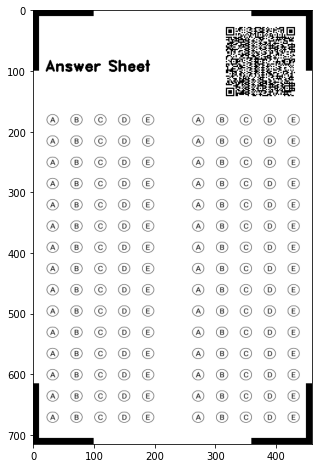

In [95]:
text = "Althayr Santos de Nazaret, 11502414"
title = 'Answer Sheet'
student_sheet = produce_mark_sheet(text, title)
plt.imshow(student_sheet);

In [97]:
cv2.imwrite('./images/example_student_mark_sheet.png', student_sheet)

True